# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [1]:
name = ''
if name == 'Andrey Ilyin':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [2]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
        import functools
        import re
        from typing import Optional

    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [3]:
from typing import List

def get_all_links(url: str) -> List[str]:
    """
    Get all the links in the webpage at the given URL.
    
    :param url: A string that is the URL of the webpage where we need to find the links
    :return: A list with all the links of the given webpage
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        soup = BeautifulSoup(response.text, 'html.parser')
        
        links = []
        for a_tag in soup.find_all('a', href=True):
            links.append(a_tag['href'])
        
        return links

    except requests.exceptions.RequestException as e:
        print(f"Error fetching the URL {url}: {e}")
        return []

In [4]:
get_all_links('http://en.wikipedia.com')[:10]

['#bodyContent',
 '/wiki/Main_Page',
 '/wiki/Wikipedia:Contents',
 '/wiki/Portal:Current_events',
 '/wiki/Special:Random',
 '/wiki/Wikipedia:About',
 '//en.wikipedia.org/wiki/Wikipedia:Contact_us',
 '/wiki/Help:Contents',
 '/wiki/Help:Introduction',
 '/wiki/Wikipedia:Community_portal']

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [5]:
def get_neighbor_pages(url: str):
    """
    Go through the links in the webpage at the given URL
    and yield the html content of each of them.
    
    :param url: A string that is the URL of the webpage
    """
    links = get_all_links(url)
    for link in links:
        try:
            # Skip empty links or links that are not valid URLs
            if not link.startswith('http'):
                continue
            response = requests.get(link)
            response.raise_for_status()
            yield response.text
        except requests.exceptions.RequestException as e:
            print(f"Error fetching the link {link}: {e}")

## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

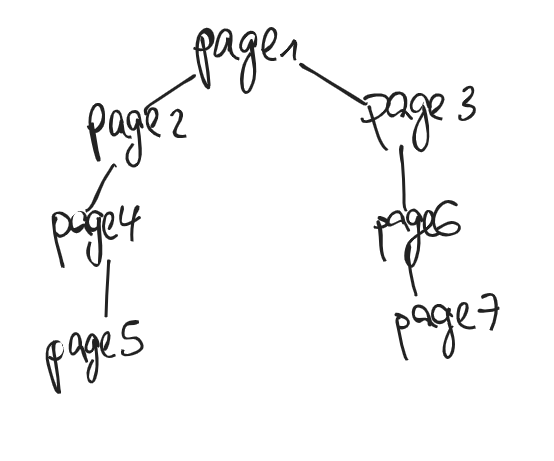

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [6]:
def get_pages_depth(url: str, depth: int):
    """
    Go as deep as the given depth, through the links in the webpage at the given URL
    and yield the html content of each of them.
    
    :param url: A string that is the URL of the webpage
    :param depth: An integer that is the depth until which the function searches
    """
    visited = set()
    
    def _crawl(url, depth):
        if depth == 0 or url in visited:
            return
        visited.add(url)
        yield url  # Yield the current page's URL

        links = get_all_links(url)
        for link in links:
            if link.startswith('http') and link not in visited:
                yield from _crawl(link, depth - 1)

    yield from _crawl(url, depth)


In [7]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [8]:
next(pages)

'http://en.wikipedia.org'

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [9]:
class ComputerScientist:
    def __init__(self, name: str, birthdate: str, major_achievements: str, alma_mater: str):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements
        self.alma_mater = alma_mater
        
    def __repr__(self):
        return f"ComputerScientist(name={self.name}, birthdate={self.birthdate}, 
        major_achievements={self.major_achievements}, alma_mater={self.alma_mater})"

# Task 5

In [14]:
def cache_decorator(func):
    cache = {}
    
    @functools.wraps(func)
    def wrapper(name: str, *args, **kwargs):
        if name in cache:
            return cache[name]
        result = func(name, *args, **kwargs)
        cache[name] = result
        return result
    
    return wrapper

@cache_decorator
def fetch_scientist(name: str) -> Optional[ComputerScientist]:
    """
    Fetch a computer scientist from Wikipedia and return a ComputerScientist object.
    
    :param name: Name of the computer scientist
    :return: ComputerScientist object if the scientist exists, None if not
    """
    # Format the name to be suitable for a Wikipedia URL
    formatted_name = name.replace(' ', '_')
    search_url = f"https://en.wikipedia.org/wiki/{formatted_name}"
    
    try:
        response = requests.get(search_url)
        if response.status_code != 200:
            print(f"Error: Could not fetch Wikipedia page for {name}.")
            return None
        
        # Extract birthdate using regex
        birthdate_match = re.search(r"Born\s*([\d{1,2}\s\w]+, \d{4})", response.text)
        birthdate = birthdate_match.group(1) if birthdate_match else "Unknown"
        
        # Extract major achievements and alma mater (for simplicity, we'll leave them as placeholders)
        major_achievements = "Major achievements not extracted."
        alma_mater = "Alma mater not extracted."
        
        # Create ComputerScientist object
        scientist = ComputerScientist(name, birthdate, major_achievements, alma_mater)
        
        # Add the wikipedia_link dynamically
        setattr(scientist, 'wikipedia_link', search_url)
        
        return scientist

    except Exception as e:
        print(f"An error occurred while fetching data for {name}: {e}")
        return None


Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [15]:
# Example Usage
if __name__ == "__main__":
    scientist = fetch_scientist('Alan Turing')
    if scientist:
        print(scientist)
        print(f"Wikipedia Link: {scientist.wikipedia_link}")
        
    # Fetch again to check caching
    scientist2 = fetch_scientist('Alan Turing')
    if scientist2:
        print(scientist2)

ComputerScientist(name=Alan Turing, birthdate=Unknown, major_achievements=Major achievements not extracted., alma_mater=Alma mater not extracted.)
Wikipedia Link: https://en.wikipedia.org/wiki/Alan_Turing
ComputerScientist(name=Alan Turing, birthdate=Unknown, major_achievements=Major achievements not extracted., alma_mater=Alma mater not extracted.)


# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Added Alan Turing to the graph.
Link found: Alan Turing -> Main Page
Link found: Alan Turing -> Wikipedia:Contents
Link found: Alan Turing -> Portal:Current events
Link found: Alan Turing -> Special:Random
Link found: Alan Turing -> Wikipedia:About
Link found: Alan Turing -> Help:Contents
Link found: Alan Turing -> Help:Introduction
Link found: Alan Turing -> Wikipedia:Community portal
Link found: Alan Turing -> Special:RecentChanges
Link found: Alan Turing -> Wikipedia:File upload wizard
Link found: Alan Turing -> Special:Search
Link found: Alan Turing -> Special:MyContributions
Link found: Alan Turing -> Special:MyTalk
Link found: Alan Turing -> Talk:Alan Turing
Link found: Alan Turing -> Wikipedia:File Upload Wizard
Link found: Alan Turing -> Special:SpecialPages
Link found: Alan Turing -> Wikipedia:Good articles*
Link found: Alan Turing -> Wikipedia:Protection policy#semi
Link found: Alan Turing -> Turing (disambiguation)
Link found: Alan Turing -> Officer of the Order of the Briti

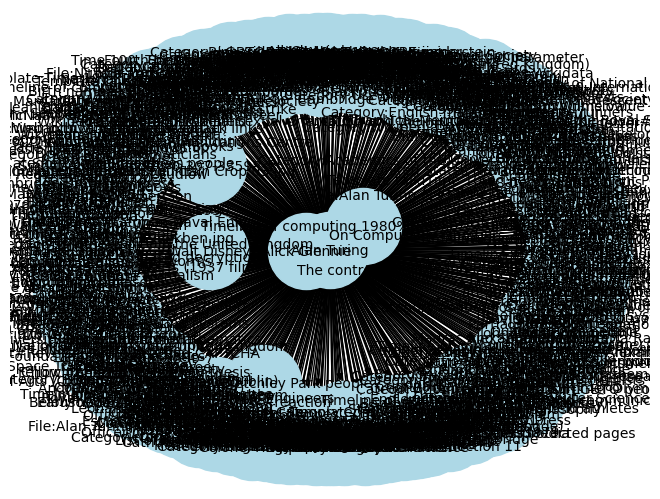


PageRank of scientists:
Main Page: 0.0012
Wikipedia:Contents: 0.0012
Portal:Current events: 0.0012
Special:Random: 0.0012
Wikipedia:About: 0.0012
Help:Contents: 0.0012
Help:Introduction: 0.0012
Wikipedia:Community portal: 0.0012
Special:RecentChanges: 0.0012
Wikipedia:File upload wizard: 0.0012
Special:Search: 0.0012
Special:MyContributions: 0.0012
Special:MyTalk: 0.0012
Talk:Alan Turing: 0.0012
Wikipedia:File Upload Wizard: 0.0012
Special:SpecialPages: 0.0012
Wikipedia:Good articles*: 0.0012
Wikipedia:Protection policy#semi: 0.0012
Turing (disambiguation): 0.0012
Officer of the Order of the British Empire: 0.0012
Fellow of the Royal Society: 0.0012
File:Alan Turing (1912-1954) in 1936 at Princeton University (cropped).jpg: 0.0012
Maida Vale: 0.0012
Wilmslow: 0.0012
Cyanide poisoning: 0.0012
Suicide: 0.0012
University of Cambridge: 0.0012
Bachelor of Arts: 0.0012
Master of Arts (Oxford, Cambridge, and Dublin): 0.0012
Princeton University: 0.0012
Doctor of Philosophy: 0.0012
Cryptanaly

In [18]:
import networkx as nx
import requests
from bs4 import BeautifulSoup

class ScientistGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.scientist_list = []

    def add_scientist(self, scientist_name: str):
        """
        Adds a scientist to the graph.
        
        :param scientist_name: Name of the computer scientist to add.
        """
        if scientist_name not in self.graph:
            # Fetch the scientist's information
            scientist = fetch_scientist(scientist_name)
            if scientist:
                self.scientist_list.append(scientist)
                self.graph.add_node(scientist_name, wikipedia_link=scientist.wikipedia_link)
                print(f"Added {scientist_name} to the graph.")
                
                # Extract links to other scientists from their Wikipedia page
                self._add_edges_from_wikipedia(scientist)

    def _add_edges_from_wikipedia(self, scientist):
        """
        Adds edges between the current scientist and others they are linked to on Wikipedia.
        
        :param scientist: The scientist object.
        """
        try:
            # Fetch Wikipedia page and find all links
            response = requests.get(scientist.wikipedia_link)
            soup = BeautifulSoup(response.text, 'html.parser')
            links = soup.find_all('a', href=True)
            
            for link in links:
                href = link['href']
                if href.startswith('/wiki/'):
                    linked_scientist = href.split('/')[-1].replace('_', ' ')
                    if linked_scientist != scientist.name and linked_scientist not in self.graph:
                        # Add edge between scientist and the linked scientist
                        self.graph.add_edge(scientist.name, linked_scientist)
                        print(f"Link found: {scientist.name} -> {linked_scientist}")
        except Exception as e:
            print(f"Error adding edges for {scientist.name}: {e}")

    def remove_scientist(self, scientist_name: str):
        """
        Removes a scientist from the graph.
        
        :param scientist_name: Name of the computer scientist to remove.
        """
        if scientist_name in self.graph:
            self.graph.remove_node(scientist_name)
            print(f"Removed {scientist_name} from the graph.")
            self.scientist_list = [s for s in self.scientist_list if s.name != scientist_name]
        else:
            print(f"{scientist_name} not found in the graph.")

    def plot(self):
        """
        Plots the graph using NetworkX.
        """
        import matplotlib.pyplot as plt
        nx.draw(self.graph, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
        plt.show()
    
    def rank_scientists(self):
        """
        Ranks scientists based on their PageRank.
        """
        ranks = nx.pagerank(self.graph)
        sorted_ranks = sorted(ranks.items(), key=lambda x: x[1], reverse=True)
        return sorted_ranks


# Example Usage
if __name__ == "__main__":
    # Create the graph
    graph = ScientistGraph()
    
    # Add some scientists
    graph.add_scientist('Alan Turing')
    graph.add_scientist('Grace Hopper')
    graph.add_scientist('Donald Knuth')

    # Visualize the graph
    print("Graph visualization:")
    graph.plot()

    # Rank scientists using PageRank
    print("\nPageRank of scientists:")
    rankings = graph.rank_scientists()
    for scientist, rank in rankings:
        print(f"{scientist}: {rank:.4f}")

    # Remove a scientist and re-rank
    print("\nRemoving Grace Hopper and re-ranking...")
    graph.remove_scientist('Grace Hopper')

    rankings = graph.rank_scientists()
    for scientist, rank in rankings:
        print(f"{scientist}: {rank:.4f}")

Show the usage of these methods in a proper way.
Feel free to add more functionalities.